In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import helper

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
data_dir = 'dog vs cat/dataset/training_set'
transform = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


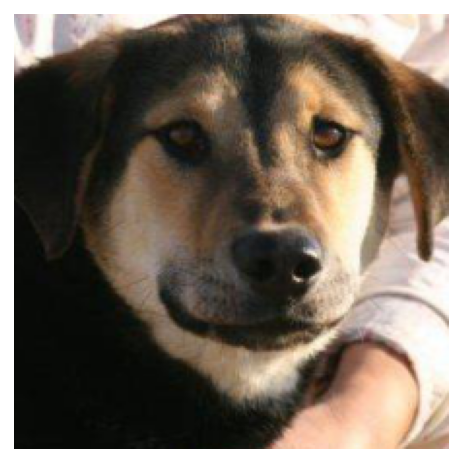

In [6]:
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

In [14]:
data_dir = 'dog vs cat/dataset'

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir+'/training_set', transform=train_transform)
test_data = datasets.ImageFolder(data_dir+'/test_set', transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


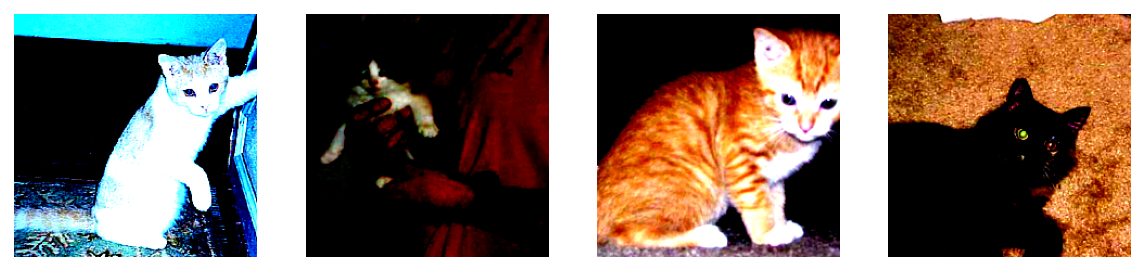

In [15]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

In [16]:
images[0].shape

torch.Size([3, 224, 224])

# Transfer learning

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [17]:
model = models.densenet121(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\tanvi/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(1024,500)),
                                       ('relu', nn.ReLU()),
                                       ('fc2', nn.Linear(500,2)),
                                       ('output', nn.LogSoftmax(dim=1))]))
model.classifier = classifier

In [19]:
import time

In [22]:
for device in ['cpu']:
    criterion = nn.NLLLoss()
    
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    model.to(device)   #decide according to forloop
    
    for ii, (inputs, labels) in enumerate(trainloader):
        
        inputs,labels = inputs.to(device) , labels.to(device)
        
        start = time.time()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if ii==3:
            break
        
        
    print(f"Device={device}; Time per batch: {(time.time()-start)/3:.3f}seconds")    

Device=cpu; Time per batch: 3.482seconds


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024,256),
                                nn.ReLU(),
                                nn.Linear(256,2),
                                nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
epochs =1 
steps = 0 
runing_loss =0 
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps+=1
        
        inputs , labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        loss = criterion(output,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        runing_loss+=loss.item()
        
        if steps % print_every == 0:
            test_loss= 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs , labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    
                    output = model.forward(inputs)
                    batch_loss= criterion(output,labels)
                    
                    test_loss+=batch_loss.item()
                    
                    #calculate accuracy
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.."
                 f"Train loss : {runing_loss/print_every:.3f}.."
                 f"Test loss: {test_loss/len(testloader)}"
                 f"Test accuracy: {accuracy/len(testloader):.3f}")
            runing_loss=0
            model.train()

Epoch 1/1..Train loss : 0.142..Test loss: 0.0458516612125095Test accuracy: 0.987
Epoch 1/1..Train loss : 0.222..Test loss: 0.04709911202371586Test accuracy: 0.984
Epoch 1/1..Train loss : 0.206..Test loss: 0.06185693199222442Test accuracy: 0.979
Epoch 1/1..Train loss : 0.130..Test loss: 0.04439421623828821Test accuracy: 0.987
Epoch 1/1..Train loss : 0.250..Test loss: 0.05693735892418772Test accuracy: 0.981
Epoch 1/1..Train loss : 0.165..Test loss: 0.05721006789826788Test accuracy: 0.986
Epoch 1/1..Train loss : 0.159..Test loss: 0.05295292366645299Test accuracy: 0.983
Epoch 1/1..Train loss : 0.164..Test loss: 0.04417891360935755Test accuracy: 0.988
Epoch 1/1..Train loss : 0.173..Test loss: 0.055793256797187496Test accuracy: 0.979
Epoch 1/1..Train loss : 0.220..Test loss: 0.06674092592584202Test accuracy: 0.976
Epoch 1/1..Train loss : 0.183..Test loss: 0.10289804036801797Test accuracy: 0.958
Epoch 1/1..Train loss : 0.188..Test loss: 0.07262269870261662Test accuracy: 0.975
Epoch 1/1..Train